In [1]:
import numpy as np
from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import ArmActionMode, JointVelocity, JointPosition, EndEffectorPoseViaPlanning, EndEffectorPoseViaIK


from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.observation_config import ObservationConfig, CameraConfig
# from rlbench.tasks.pick_described_object import PickDescribedObject
from rlbench.tasks import PutGroceriesInCupboard, PickAndLift, StackBlocks, PlaceHangerOnRack, PickDescribedObject, TakeLidOffSaucepan, SetTheTable
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import torch 
import random
import os, time
from pyrep.const import RenderMode

In [2]:
def check_and_make(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)


In [3]:
camera = CameraConfig(image_size=(448, 448), depth=False, point_cloud=False, mask=False)
obs_config = ObservationConfig(left_shoulder_camera=camera, right_shoulder_camera=camera, front_camera=camera, overhead_camera=camera)
obs_config.front_camera.render_mode = RenderMode.OPENGL
env = Environment(
    action_mode=MoveArmThenGripper(
        arm_action_mode=EndEffectorPoseViaPlanning(absolute_mode=True, collision_checking=True), gripper_action_mode=Discrete()),
    obs_config=obs_config,
    headless=False)
env.launch()
task = env.get_task(PickDescribedObject)

In [4]:
def get_pose(task):
    quat = task._scene.robot.arm.get_tip().get_quaternion()
    quat2euler = R.from_quat(quat).as_euler('xyz')
    euler = task._scene.robot.arm.get_tip().get_orientation()
    euler2quat = R.from_euler('xyz', euler).as_quat()

    print(f"quat: {quat}, euler2quat: {euler2quat}, \n euler: {euler}, quat2euler: {quat2euler}")
    return quat, euler, quat2euler, euler2quat

In [ ]:
task._scene.get_demo()

In [6]:
task.reset()

(['put the chocolate jello in the basket',
  'pick up the chocolate jello and place in the basket',
  'I want to put away the chocolate jello'],
 <rlbench.backend.observation.Observation at 0x7b18ef9a0fd0>)

In [13]:
env.shutdown()  

[CoppeliaSim:loadinfo]   done.


In [ ]:
Image.fromarray(task._scene.get_observation().front_rgb,'RGB')

In [ ]:
task._scene.task.success()[0]

In [6]:
def randomize_pose(task,seed):
    np.random.seed()
    while True:
        try:
            pos_lower_bound = np.array([-0.2, -0.35, task._scene._workspace_minz])
            pos_upper_bound = np.array([task._scene._workspace_maxx, 0.35, 1.3])
            rot_lower_bound = np.array([-np.pi/2, 0, -np.pi/2])
            rot_upper_bound = np.array([np.pi/2, np.pi/2, np.pi/2])
            pos = np.random.uniform(pos_lower_bound, pos_upper_bound)
            euler = np.random.uniform(rot_lower_bound, rot_upper_bound)
            euler[0] = np.clip(np.random.normal(0, np.pi/8),-np.pi/2,np.pi/2)
            euler[1] = -np.clip(abs(np.random.normal(0,np.pi/8)),0, np.pi/2)
            trans = lambda rx: rx - np.pi if rx > 0 else rx + np.pi 
            euler[0] = trans(euler[0])
            quat = R.from_euler('xyz', euler).as_quat()
            joint_position = task._scene.robot.arm.solve_ik_via_sampling(position=pos, euler=euler, trials=10)
            task.step(np.concatenate([pos, quat, [0]]))
            break
        except Exception as e:
            print(e)
            continue
    return joint_position, pos, euler, quat

In [7]:
def get_data(task, variation_num):
    obs = task._scene.get_observation()
    img = obs.front_rgb
    get_pose(task)
    plt.imshow(img)
    plt.show()
    gripper_pose = obs.gripper_pose
    gripper_open = obs.gripper_open
    object_pos = task._task.get_graspable_objects()[variation_num].get_position()
    target_pos = task._task.dropin_box.get_position()
    return img, gripper_pose, gripper_open, object_pos, target_pos

def pose2action(pose, open):
    return np.concatenate([pose[:3], R.from_quat(pose[3:]).as_euler('xyz'), [open]])
    

Could not find a valid joint configuration for desired end effector pose.
Could not find a valid joint configuration for desired end effector pose.
Could not find a valid joint configuration for desired end effector pose.
quat: [-0.8107208   0.56121403 -0.14942007 -0.07378601], euler2quat: [0.79709356 0.58040601 0.02040652 0.16539133], 
 euler: [2.84624004 0.16014001 1.23487127], quat2euler: [-3.09073589 -0.33111256 -1.21949812]


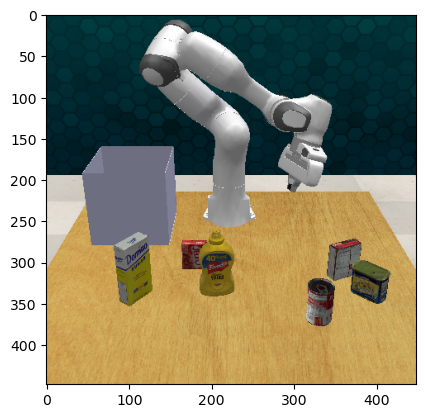

quat: [-0.81088752  0.56099415 -0.14929937 -0.07386988], euler2quat: [0.79728632 0.58016159 0.02042714 0.16531722], 
 euler: [2.84629321 0.15992974 1.23427618], quat2euler: [-3.09112044 -0.33102347 -1.21887235]


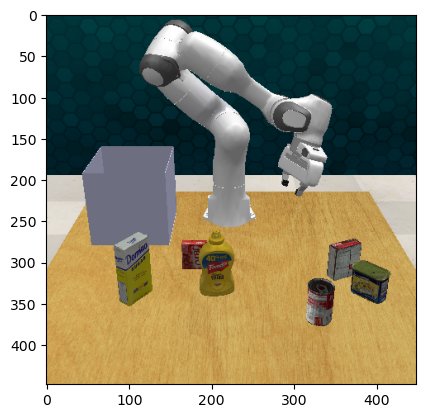

A path could not be found. Most likely due to the target being inaccessible or a collison was detected.
quat: [-0.93158948  0.32768491 -0.15564238 -0.02321901], euler2quat: [ 0.92440422  0.34743801 -0.10434933  0.11779172], 
 euler: [2.9899323  0.27835315 0.69774771], quat2euler: [-3.07986807 -0.3101554  -0.68611532]


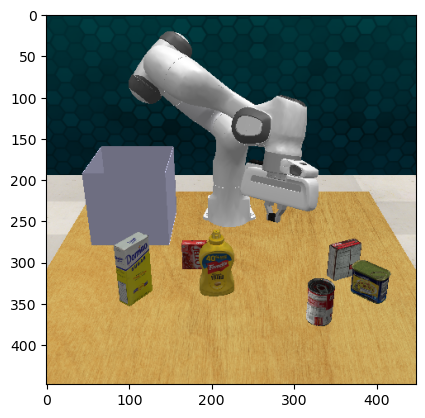

quat: [-0.93154114  0.32775685 -0.15580374 -0.0230617 ], euler2quat: [ 0.92435129  0.34751697 -0.104553    0.11779356], 
 euler: [2.99009061 0.27875397 0.6979264 ], quat2euler: [-3.07941862 -0.31035051 -0.6863618 ]


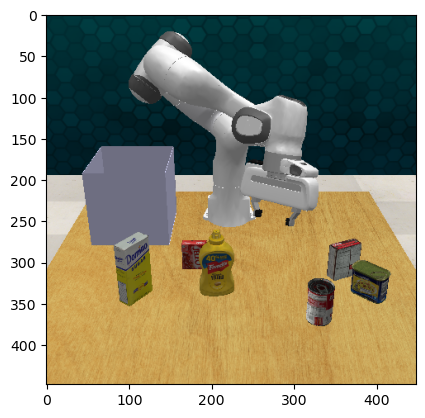

Could not find a valid joint configuration for desired end effector pose.
Could not find a valid joint configuration for desired end effector pose.
quat: [-7.45465457e-01  6.64211810e-01 -3.82731232e-05 -5.57132773e-02], euler2quat: [0.74751518 0.66190414 0.05531972 0.00661039], 
 euler: [ 3.0581522  -0.07402135  1.45255268], quat2euler: [ 3.05825377 -0.07413578 -1.45255155]


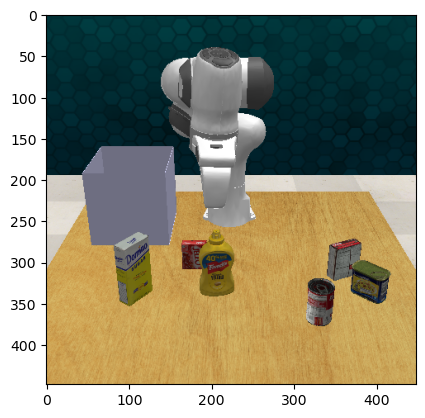

quat: [-7.45577455e-01  6.64086282e-01 -2.09280755e-04 -5.57110682e-02], euler2quat: [0.74762502 0.66178022 0.05529507 0.00679841], 
 euler: [ 3.05791616 -0.07374868  1.45221829], quat2euler: [ 3.05847158 -0.07437452 -1.45221272]


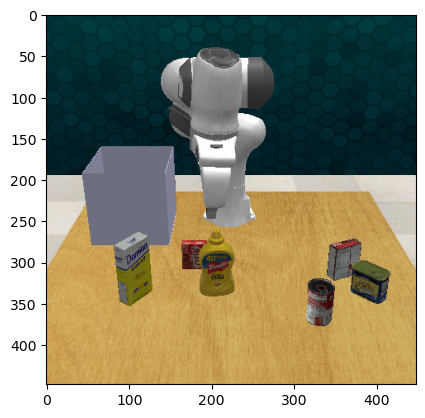

quat: [ 0.28190541  0.95640707 -0.03576715  0.06734759], euler2quat: [ 0.28749398 -0.95474196 -0.0667938  -0.03679103], 
 euler: [ 3.03436637  0.10887247 -2.56246901], quat2euler: [-3.11079955  0.14954609  2.57062441]


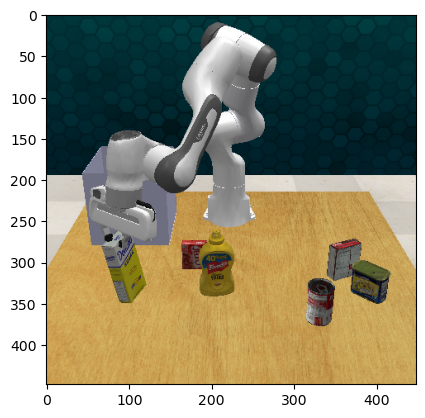

Could not find a valid joint configuration for desired end effector pose.
Could not find a valid joint configuration for desired end effector pose.
quat: [-0.79192507 -0.5547412  -0.16064483  0.19826834], euler2quat: [-0.78685616  0.56190776 -0.13343266  0.21751499], 
 euler: [-2.62657261  0.03446892 -1.23119771], quat2euler: [-2.98671512 -0.49429649  1.1829691 ]


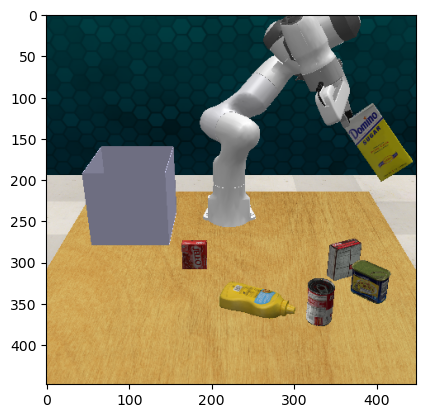

Could not find a valid joint configuration for desired end effector pose.
Could not find a valid joint configuration for desired end effector pose.
Could not find a valid joint configuration for desired end effector pose.
quat: [-0.97655666 -0.16324322 -0.1199375   0.0728275 ], euler2quat: [-0.97311113  0.18266332  0.0875641   0.10964199], 
 euler: [-2.95495629  0.21206014 -0.3511821 ], quat2euler: [-3.0346938  -0.26098125  0.31721912]


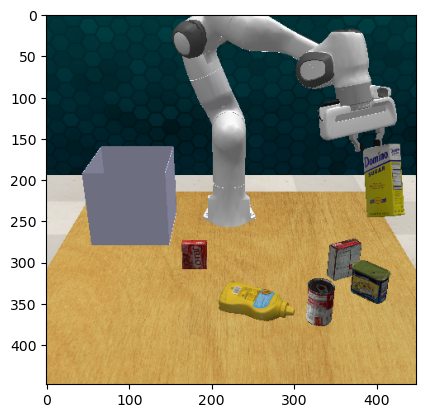

quat: [-0.87859774  0.47045714 -0.06379145 -0.05164083], euler2quat: [0.87631548 0.47469469 0.00801275 0.0816818 ], 
 euler: [2.98994184 0.0635472  0.98805815], quat2euler: [ 3.11046244 -0.16138324 -0.98071118]


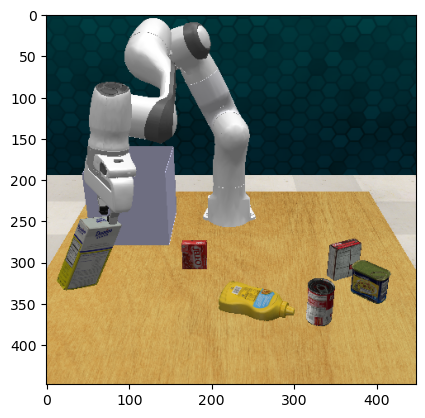

In [262]:
task = env.get_task(PickDescribedObject)
variation_num = 4
seed = np.random.randint(0, 100000)
img_root = lambda variation_num, episode_num: f"./datasets/pick_described_object/variation_{variation_num}/episode_{episode_num}/"

img_paths = []
gripper_poses = []
object_poses = []
target_poses = []
stages = []
actions = []
items = []
id = 0
episode_num = 0
trial_times = 3
while True:
    task.set_variation(variation_num)
    check_and_make(img_root(variation_num, episode_num))
    np.random.seed(seed)
    task.reset()
    for i in range(trial_times):

        #stage 0
        stage = 0
        joint_position, pos, euler, quat = randomize_pose(task,seed)
        
        img, gripper_pose, gripper_open, object_pos, target_pos = get_data(task, variation_num)
        task_action = np.concatenate([pos, quat, [1]])
        task.step(task_action)
        img_path = img_root(variation_num, episode_num)+f"{id}.npy"
        np.save(img_path, img)
        img_paths.append(img_path)
        gripper = pose2action(gripper_pose, gripper_open)

        gripper_poses.append(gripper)
        items.append(variation_num)
        object_poses.append(object_pos)
        target_poses.append(target_pos)

        stages.append(stage)
        action = pose2action(gripper_pose, 1)
        actions.append(action)
        id += 1

        img, gripper_pose, gripper_open, object_pos, target_pos = get_data(task, variation_num)
        waypoint_pose = task._task.get_waypoints()[stage].get_waypoint_object().get_pose()
        img_path = img_root(variation_num, episode_num)+f"{id}.npy"

        np.save(img_path, img)
        img_paths.append(img_path)
        gripper = pose2action(gripper_pose, gripper_open)
        gripper_poses.append(gripper)
        items.append(variation_num)
        object_poses.append(object_pos)
        target_poses.append(target_pos)
        stages.append(stage)
        action = pose2action(waypoint_pose,0)
        actions.append(action)
        id+= 1
    task_action = np.concatenate([waypoint_pose, [0]])
    task.step(task_action)


    stage = 1
    img, gripper_pose, gripper_open, object_pos, target_pos = get_data(task, variation_num)
    waypoint_pose = task._task.get_waypoints()[stage].get_waypoint_object().get_pose()
    img_path = img_root(variation_num, episode_num)+f"{id}.npy"
    np.save(img_path, img)
    img_paths.append(img_path)
    gripper = pose2action(gripper_pose, gripper_open)
    gripper_poses.append(gripper)
    items.append(variation_num)
    object_poses.append(object_pos)
    target_poses.append(target_pos)
    stages.append(stage)
    action_open = 1
    action = pose2action(waypoint_pose, action_open)
    actions.append(action)
    id += 1 
    
    for i in range(trial_times):
        randomize_pose(task,seed)
        img, gripper_pose, gripper_open, object_pos, target_pos = get_data(task, variation_num)
        waypoint_pose = task._task.get_waypoints()[stage].get_waypoint_object().get_pose()
        img_path = img_root(variation_num, episode_num)+f"{id}.npy"
        np.save(img_path, img)
        img_paths.append(img_path)
        gripper = pose2action(gripper_pose, gripper_open)
        gripper_poses.append(gripper)
        items.append(variation_num)
        object_poses.append(object_pos)
        target_poses.append(target_pos)
        stages.append(stage)
        action = pose2action(waypoint_pose, action_open)
        actions.append(action)
        id += 1
    task_action = np.concatenate([waypoint_pose, [action_open]])
    task.step(task_action)

    # stage = 2
    # img, gripper_pose, gripper_open, object_pos, target_pos = get_data(task, variation_num)
    # waypoint_pose = task._task.get_waypoints()[stage].get_waypoint_object().get_pose()
    # action_open = 0 if stage == 1 else 1
    # task_action = np.concatenate([waypoint_pose, [action_open]])
    # task.step(task_action)
    # img_path = img_root(variation_num, episode_num)+f"{id}.npy"
    # np.save(img_path, img)
    # img_paths.append(img_path)
    # gripper = pose2action(gripper_pose, gripper_open)
    # gripper_poses.append(gripper)
    # items.append(variation_num)
    # object_poses.append(object_pos)
    # target_poses.append(target_pos)
    # stages.append(stage)
    # action = pose2action(waypoint_pose, action_open)
    # actions.append(action)
    # id += 1

    #stage 1
    # for stage in [1,2]:
    #     img, gripper_pose, gripper_open, object_pos, target_pos = get_data(task, variation_num)
    #     waypoint_pose = task._task.get_waypoints()[stage].get_waypoint_object().get_pose()
    #     action_open = 0 if stage == 1 else 1
    #     task_action = np.concatenate([waypoint_pose, [action_open]])
    #     task.step(task_action)
    #     img_path = img_root(variation_num, episode_num)+f"{id}.npy"
    #     np.save(img_path, img)
    #     img_paths.append(img_path)
    #     gripper = pose2action(gripper_pose, gripper_open)
    #     gripper_poses.append(gripper)
    #     items.append(variation_num)
    #     object_poses.append(object_pos)
    #     target_poses.append(target_pos)
    #     stages.append(stage)
    #     action = pose2action(waypoint_pose, action_open)
    #     actions.append(action)
    #     id += 1
    
    # print(f"gripper_pose:{gripper_pose} {gripper_open}\n obj pos{object_pos}\n target {target_pos}")
    time.sleep(1)
    break

In [267]:
desc,_ = task.reset()

In [276]:
random.sample(desc,1)[0]

'pick up the sugar and place in the basket'

In [ ]:
task.get_demos

In [210]:
np.stack(gripper_poses)[:,3:6]

array([[-2.99817302e+00, -2.05426920e-01,  6.91328610e-01],
       [-2.99806648e+00, -2.05652885e-01,  6.91414831e-01],
       [ 2.54532423e+00, -4.07766688e-01, -7.16453074e-01],
       [ 2.54477845e+00, -4.08269311e-01, -7.16862394e-01],
       [ 2.84848326e+00, -1.10902946e+00,  1.05037284e+00],
       [-2.88937340e+00, -9.74893327e-01,  1.77418744e-01],
       [-2.88935858e+00, -9.75856202e-01,  1.77648736e-01],
       [-3.14076510e+00,  3.45594161e-04,  8.39248834e-01],
       [ 3.13995830e+00, -6.81083891e-04,  3.14058410e+00]])

In [222]:
lower_bound = np.array([task._scene._workspace_minx, task._scene._workspace_miny, task._scene._workspace_minz])
upper_bound = np.array([task._scene._workspace_maxx, task._scene._workspace_maxy, task._scene._workspace_maxz])
while True:
    task.reset()
    try:
        # pos = np.random.uniform(lower_bound, upper_bound)
        # pos = task._scene.robot.arm.get_position()
        pos = np.array([0.5, 0, 1])
        rot = np.random.uniform(-np.pi, np.pi, 3)
        rot[0] = 0
        # rot[1] = 0
        joint_position = task._scene.robot.arm.solve_ik_via_sampling(position=pos, euler=rot)
        task._scene.robot.arm.set_joint_positions(joint_position[0], disable_dynamics=True)
        task._scene.robot.gripper.set_joint_positions([0.0, 0.0])
        # print(task._scene.robot.gripper.get_joint_positions())
        task._scene.get_demo(callable_each_step=lambda obs: print(task._scene.robot.gripper.get_orientation())) 
        # frgb1 = task._scene.get_observation().front_rgb
        # plt.imshow(frgb1)
        # plt.show()
        # task._scene.robot.gripper.set_joint_positions([0.03999999910593033, 0.03999999910593033])
        # frgb2 = task._scene.get_observation().front_rgb
        # plt.imshow(frgb2)
        # plt.show()
    except Exception as e:
        print(e)
        pass


Could not find a valid joint configuration for desired end effector pose.


KeyboardInterrupt: 

In [5]:

# Define the function to be executed in each process
def process_variation(i, task, manager_dict, lock):
    local_train_imgs = []
    local_train_instructions = []
    local_train_cots = []
    local_train_target_item_poses = []
    local_train_gripper_poses = []
    local_train_basket_positions = []
    local_train_actions = []

    local_test_imgs = []
    local_test_instructions = []
    local_test_cots = []
    local_test_target_item_poses = []
    local_test_gripper_poses = []
    local_test_basket_positions = []
    local_test_actions = []

    camera = CameraConfig(image_size=(224, 224), depth=False, point_cloud=False, mask=False)
    obs_config = ObservationConfig(left_shoulder_camera=camera, right_shoulder_camera=camera, front_camera=camera, overhead_camera=camera)

    env = Environment(
        action_mode=MoveArmThenGripper(
            arm_action_mode=EndEffectorPoseViaPlanning(absolute_mode=True, collision_checking=True), gripper_action_mode=Discrete()),
        obs_config=obs_config,
        headless=True)
    env.launch()
    task = env.get_task(PickDescribedObject)
    task.set_variation(i)

    j = 0
    while j < 10:
        try:
            imgs, instructions, cots, target_item_poses, gripper_poses, basket_positions, actions = run_episode(task, i)
            j += 1
            print(f"variation{i}, epoisode{j} done")
            if j < 8:
                local_train_imgs += imgs
                local_train_instructions += instructions
                local_train_cots += cots
                local_train_target_item_poses += target_item_poses
                local_train_gripper_poses += gripper_poses
                local_train_basket_positions += basket_positions
                local_train_actions += actions
            else:
                local_test_imgs += imgs
                local_test_instructions += instructions
                local_test_cots += cots
                local_test_target_item_poses += target_item_poses
                local_test_gripper_poses += gripper_poses
                local_test_basket_positions += basket_positions
                local_test_actions += actions
        except Exception as e:
            print(e)
            pass

    with lock:
        manager_dict['train_imgs'] += local_train_imgs
        manager_dict['train_instructions'] += local_train_instructions
        manager_dict['train_cots'] += local_train_cots
        manager_dict['train_target_item_poses'] += local_train_target_item_poses
        manager_dict['train_gripper_poses'] += local_train_gripper_poses
        manager_dict['train_basket_positions'] += local_train_basket_positions
        manager_dict['train_actions'] += local_train_actions

        manager_dict['test_imgs'] += local_test_imgs
        manager_dict['test_instructions'] += local_test_instructions
        manager_dict['test_cots'] += local_test_cots
        manager_dict['test_target_item_poses'] += local_test_target_item_poses
        manager_dict['test_gripper_poses'] += local_test_gripper_poses
        manager_dict['test_basket_positions'] += local_test_basket_positions
        manager_dict['test_actions'] += local_test_actions



In [6]:
manager = Manager()
lock = manager.Lock()

# Create shared lists
manager_dict = manager.dict({
    'train_imgs': [],
    'train_instructions': [],
    'train_cots': [],
    'train_target_item_poses': [],
    'train_gripper_poses': [],
    'train_basket_positions': [],
    'train_actions': [],
    'test_imgs': [],
    'test_instructions': [],
    'test_cots': [],
    'test_target_item_poses': [],
    'test_gripper_poses': [],
    'test_basket_positions': [],
    'test_actions': []
})

task = env.get_task(PickDescribedObject)

processes = []
for i in range(5):
    p = multiprocessing.Process(target=process_variation, args=(i, task, manager_dict, lock))
    processes.append(p)
    p.start()

for p in processes:
    p.join()

print('Data collection done!')
print(manager_dict['train_imgs'])

In [ ]:
train_data = {
    'imgs': manager_dict['train_imgs'],
    'instructions': manager_dict['train_instructions'],
    'cots': manager_dict['train_cots'],
    'target_item_poses': manager_dict['train_target_item_poses'],
    'gripper_poses': manager_dict['train_gripper_poses'],
    'basket_positions': manager_dict['train_basket_positions'],
    'actions': manager_dict['train_actions']
}
test_data = {
    'imgs': manager_dict['test_imgs'],
    'instructions': manager_dict['test_instructions'],
    'cots': manager_dict['test_cots'],
    'target_item_poses': manager_dict['test_target_item_poses'],
    'gripper_poses': manager_dict['test_gripper_poses'],
    'basket_positions': manager_dict['test_basket_positions'],
    'actions': manager_dict['test_actions']
}

torch.save(train_data, './datasets/pick_described_object/train.pt')
torch.save(test_data, './datasets/pick_described_object/test.pt')